Qubits: 4
第 1 步: E = 0.77868178 Ha, β_1 = -0.000000
第 2 步: E = 0.77634948 Ha, β_2 = 0.036137
第 3 步: E = 0.76901964 Ha, β_3 = 0.071539
第 4 步: E = 0.75472714 Ha, β_4 = 0.105414
第 5 步: E = 0.73213698 Ha, β_5 = 0.136929
第 6 步: E = 0.70069816 Ha, β_6 = 0.165248
第 7 步: E = 0.66071397 Ha, β_7 = 0.189598
第 8 步: E = 0.61330046 Ha, β_8 = 0.209341
第 9 步: E = 0.56022756 Ha, β_9 = 0.224058
第 10 步: E = 0.50366834 Ha, β_10 = 0.233598
第 11 步: E = 0.44590862 Ha, β_11 = 0.238099
第 12 步: E = 0.38907866 Ha, β_12 = 0.237963
第 13 步: E = 0.33495652 Ha, β_13 = 0.233787
第 14 步: E = 0.28486569 Ha, β_14 = 0.226279
第 15 步: E = 0.23966118 Ha, β_15 = 0.216173
第 16 步: E = 0.19977873 Ha, β_16 = 0.204153
第 17 步: E = 0.16531666 Ha, β_17 = 0.190812
第 18 步: E = 0.13612445 Ha, β_18 = 0.176634
第 19 步: E = 0.11188165 Ha, β_19 = 0.161996
第 20 步: E = 0.09216031 Ha, β_20 = 0.147184
第 21 步: E = 0.07647057 Ha, β_21 = 0.132422
第 22 步: E = 0.06429277 Ha, β_22 = 0.117887
第 23 步: E = 0.05510032 Ha, β_23 = 0.103737
第 24 步: E = 0.0483

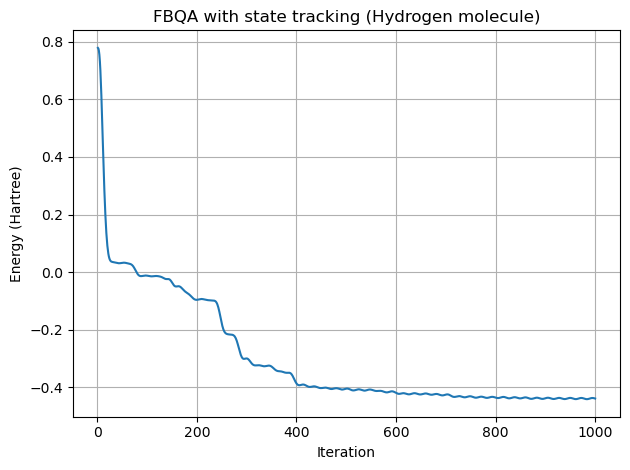

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.qchem import molecule
from pennylane import commutator
import matplotlib.pyplot as plt

# 1. 设置分子结构
symbols = ["H", "H"]
coordinates = np.array([[0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.74]])  # 单位 Å

# 2. 分子哈密顿量（cost Hamiltonian）
H_c, qubits = qml.qchem.molecular_hamiltonian(
    symbols, coordinates, method='pyscf', basis='sto-3g'
)
print("Qubits:", qubits)

# 3. Driver Hamiltonian
def build_driver_h(n):
    return qml.Hamiltonian([-1.0] * n, [qml.PauliX(i) for i in range(n)])

driver_h = build_driver_h(qubits)

# 4. 构造 commutator 哈密顿量
def build_commutator_hamiltonian(H_d, H_c):
    comm_terms = []
    coeffs_d, ops_d = H_d.terms()
    coeffs_c, ops_c = H_c.terms()
    for c1, op1 in zip(coeffs_d, ops_d):
        for c2, op2 in zip(coeffs_c, ops_c):
            try:
                comm = commutator(op1, op2)
                if isinstance(comm, qml.ops.op_math.Sum) and len(comm.operands) == 0:
                    continue
                comm_terms.append(1j * c1 * c2 * comm)
            except Exception as e:
                print(f"跳过 [{op1}, {op2}]：{e}")
                continue
    return sum(comm_terms).simplify()

comm_h = build_commutator_hamiltonian(driver_h, H_c)

# 5. 初始化量子态：|+>^n
dev = qml.device("default.qubit", wires=qubits)
@qml.qnode(dev)
def plus_state():
    for w in range(qubits):
        qml.Hadamard(w)
    return qml.state()

# 6. 单步 FALQON 演化矩阵
def single_falqon_unitary(beta_k, delta_t, cost_h, driver_h):
    U_cost = qml.ApproxTimeEvolution(cost_h, delta_t, 1)
    U_driver = qml.ApproxTimeEvolution(driver_h, beta_k * delta_t, 1)
    return qml.matrix(U_driver @ U_cost, wire_order=range(qubits))

# 7. 测量期望值 ⟨ψ|H|ψ⟩
def measure_expectation(state, H):
    H_mat = qml.matrix(H, wire_order=range(qubits))
    return np.real(np.vdot(state, H_mat @ state))

# 8. 主流程：状态保留式 FALQON
def run_fbqa_state_tracking(H, driver_h, comm_h, n_steps, beta_1, delta_t):
    beta_list = [beta_1]
    energy_list = []

    state = plus_state()

    for i in range(n_steps):
        # 计算 feedback beta
        exp_comm = measure_expectation(state, comm_h)
        next_beta = -delta_t * exp_comm
        beta_list.append(next_beta)

        # 应用下一步 unitary
        U_k = single_falqon_unitary(next_beta, delta_t, H, driver_h)
        state = U_k @ state

        # 计算能量
        energy = measure_expectation(state, H)
        energy_list.append(energy)

        print(f"第 {i+1} 步: E = {energy:.8f} Ha, β_{i+1} = {next_beta:.6f}")

    return beta_list, energy_list

# 9. 设置参数并运行
n_steps = 1000
delta_t = 0.1
beta_1 = 0.0

res_beta, res_energies = run_fbqa_state_tracking(H_c, driver_h, comm_h, n_steps, beta_1, delta_t)

# 10. 可视化
plt.plot(range(1, n_steps + 1), res_energies)
plt.xlabel("Iteration")
plt.ylabel("Energy (Hartree)")
plt.title("FBQA with state tracking (Hydrogen molecule)")
plt.grid(True)
plt.tight_layout()
plt.show()
